In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('bank+marketing/bank/bank-full.csv', sep=';')

In [5]:
df.head().T

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [6]:
using_columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

In [7]:
df = df[using_columns]

In [74]:
from sklearn.model_selection import train_test_split, KFold

In [19]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = (df_train['y'] == 'yes').values
y_val = (df_val['y'] == 'yes').values
y_test = (df_test['y'] == 'yes').values

del df_train['y']
del df_val['y']
del df_test['y']

In [17]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [38]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [61]:
from sklearn.metrics import roc_curve, auc, recall_score, precision_score

In [34]:
fpr, tpr, thresholds = roc_curve(y_train, -df_train['age'])

In [35]:
auc(fpr, tpr)

np.float64(0.509524937703519)

In [46]:
for col in numerical:
    fpr, tpr, thresholds = roc_curve(y_train, df_train[col])
    auc_val = auc(fpr, tpr)
    if auc_val < 0.5:
        fpr, tpr, thresholds = roc_curve(y_train, -df_train[col])
        auc_val = auc(fpr, tpr)

    print(f'{auc_val:5.3f} - {col}')

0.510 - age
0.595 - balance
0.526 - day
0.809 - duration
0.577 - campaign
0.593 - pdays
0.603 - previous


In [30]:
import matplotlib.pyplot as plt

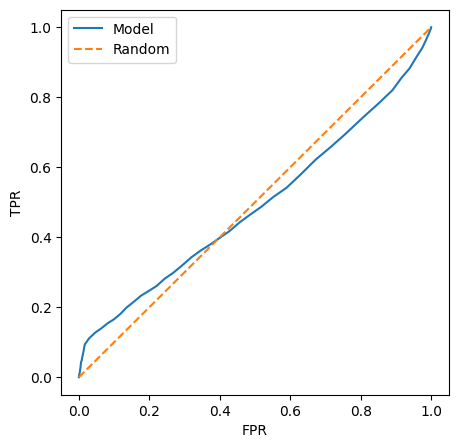

In [31]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [47]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [51]:
dv = DictVectorizer(sparse = False)
train_d = df_train.to_dict(orient = 'records')
X_train = dv.fit_transform(train_d)

In [54]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [55]:
val_d = df_val.to_dict(orient = 'records')
X_val = dv.transform(val_d)

In [56]:
y_pred_val = model.predict_proba(X_val)[:,1]

In [60]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
round(auc(fpr, tpr), 3)

np.float64(0.91)

/Users/karpenkoanton/machine-learning-zoomcamp-homework/mlz-hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/8x/8b7v71z91b12lcp68l52ngdc0000gn/T/ipykernel_8301/2055541066.py:11: RuntimeWarning: invalid value encountered in scalar divide
  f1_ = 2 * p_ * r_ / (p_ + r_)


np.float64(0.585)

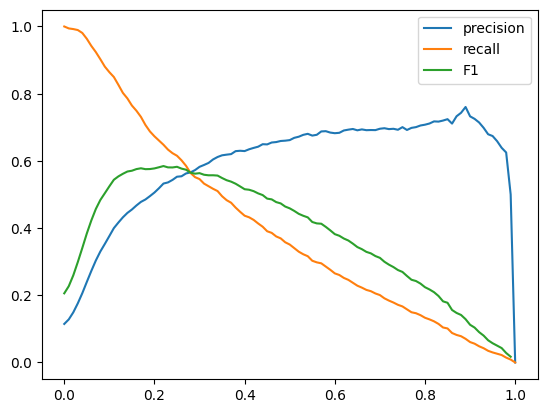

In [73]:
p, r, f1 = [], [], []
ts = [i * 0.01 for i in range(0, 101)]
for t in ts:
    decisions = (y_pred_val >= t)
    p_ = precision_score(y_val, decisions)
    p.append(p_)

    r_ = recall_score(y_val, decisions)
    r.append(r_)

    f1_ = 2 * p_ * r_ / (p_ + r_)
    f1.append(f1_)

plt.plot(ts, p, label = 'precision')
plt.plot(ts, r, label = 'recall')
plt.plot(ts, f1, label = 'F1')
plt.legend()
round(max(f1), 3)

In [80]:
import numpy as np

In [81]:


for cp in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_kf = df_full_train.iloc[train_idx]
        df_val_kf = df_full_train.iloc[val_idx]
    
        y_train = (df_train_kf['y'] == 'yes').values
        del df_train_kf['y']
        
    
        dv = DictVectorizer(sparse = False)
        train_d = df_train_kf.to_dict(orient = 'records')
        X_train = dv.fit_transform(train_d)
    
        model = LogisticRegression(solver='liblinear', C=cp, max_iter=1000)
        model.fit(X_train, y_train)
    
        y_val = (df_val_kf['y'] == 'yes').values
        del df_val_kf['y']
        val_d = df_val_kf.to_dict(orient = 'records')
        X_val = dv.transform(val_d)
        
        y_pred_val = model.predict_proba(X_val)[:, 1]
    
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
        scores.append(auc(fpr, tpr))

    print(np.mean(scores), np.std(scores)

(np.float64(0.9058437388889292), np.float64(0.005751414250417919))